In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from functools import partial

%matplotlib inline

In [2]:
import logging
logging.basicConfig(level=logging.CRITICAL)

In [3]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

# ELFI - Engine for Likelihood-Free Inference


European Meeting of Statisticians
July 25th, 2017

Antti Kangasrääsiö
Aalto University, Probabilistic Machine Learning Research Group

Joint work with:
Jarno Lintusaari (Aalto), Henri Vuollekoski (Aalto), Kusti Skytén (Aalto), Marko Järvenpää (Aalto), Michael Gutmann (University of Edinburgh), Aki Vehtari (Aalto), Jukka Corander (University of Oslo), Samuel Kaski (Aalto)

## Example: the 2nd order Moving Average model (MA2)

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2}
$$

In [4]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    t1 = np.atleast_2d(t1).reshape(-1,1)
    t2 = np.atleast_2d(t2).reshape(-1,1)
    w = random_state.randn(batch_size, n_obs+2)
    y = w[:, 2:] + (t1 * w[:, 1:-1]) + (t2 * w[:, :-2])
    return y 

### Generate some "observed" data:

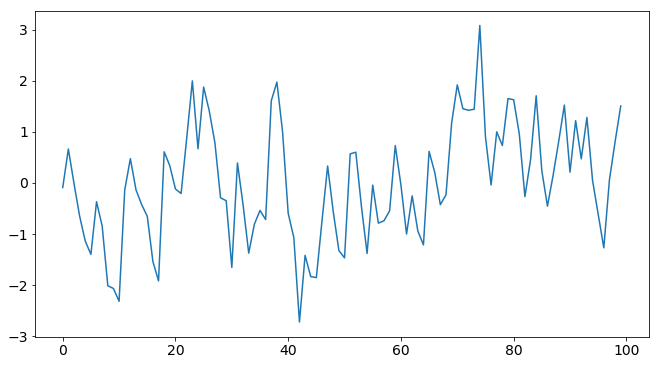

In [5]:
# true parameters
t1_true = 0.6
t2_true = 0.2

# Set up observed data y with some random seed
rs = np.random.RandomState(2017)
y_obs = MA2(t1_true, t2_true, random_state=rs)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.flatten());

### To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:

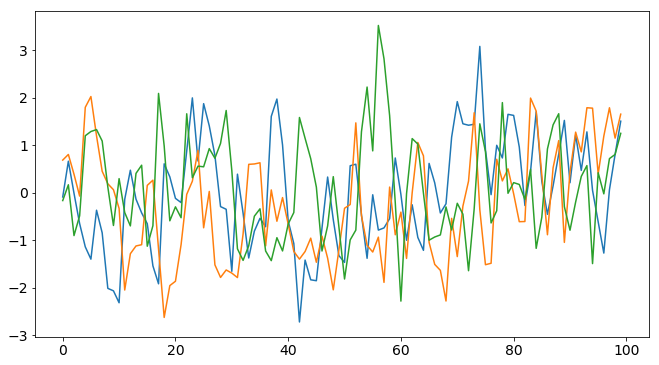

In [6]:
plt.figure(figsize=(11, 6));
plt.plot(y_obs.flatten());
plt.plot(MA2(t1_true, t2_true, random_state=rs).flatten());
plt.plot(MA2(t1_true, t2_true, random_state=rs).flatten());

### How can you compare these?

### Comparing noisy data

Calculate the discrepancy (distance) between some summary statistics, like the first two autocovariances:

In [7]:
def autocov(x, lag=1):
    mu = np.mean(x, axis=1, keepdims=True)
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1, keepdims=True) - mu**2.
    return C

def distance(*simulated, observed):
    d = np.linalg.norm(np.array(simulated) - np.array(observed),
                       ord=2, axis=0)
    return d

And then what?

In [8]:
import elfi

## Using ELFI to infer the parameters

In [51]:
elfi.new_model()
t1 = elfi.Prior(scipy.stats.uniform, 0, 2, name="t1")
t2 = elfi.Prior('uniform', 0, 2, name="t2")

In [52]:
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

In [53]:
S1 = elfi.Summary(autocov, Y, name="S1")

autocov2 = partial(autocov, lag=2)
S2 = elfi.Summary(autocov2, Y, name="S2")

In [54]:
d = elfi.Discrepancy(distance, S1, S2, name="d")

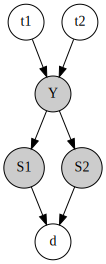

In [55]:
elfi.draw(d)

### To demonstrate customizability, let's change the prior

In [56]:
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size,
                                    random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)
        return p

class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, 
                                     random_state=random_state)
        return t2
    
    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)
        return p

### These priors sample from a triangle

$-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$

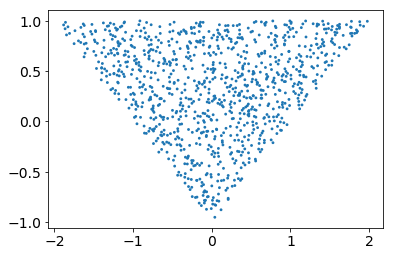

In [57]:
t1_1000 = CustomPrior_t1.rvs(2, 1000)
t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=8, edgecolor='none');

### Redefine the model with these priors

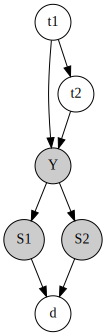

In [58]:
elfi.new_model()

t1 = elfi.Prior(CustomPrior_t1, 2)
t2 = elfi.Prior(CustomPrior_t2, t1, 1)
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov2, Y)
d = elfi.Discrepancy(distance, S1, S2)

elfi.draw(d)

### Now we just sample *a lot* to get an approximate posterior

In [59]:
# make sure we have the native client
from elfi.clients.native import set_as_default
set_as_default()

In [60]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

%time result = rej.sample(100000, n_sim=1000000)

CPU times: user 10.4 s, sys: 400 ms, total: 10.8 s
Wall time: 10.8 s


In [61]:
result.summary()

Method: Rejection
Number of samples: 100000
Number of simulations: 1000000
Threshold: 0.421
Sample means: t1: 0.608, t2: 0.447


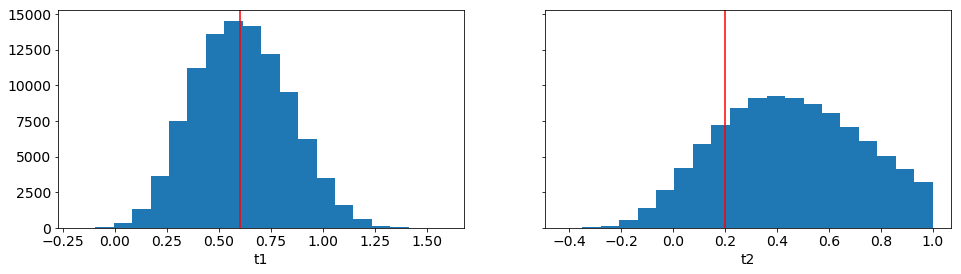

In [62]:
ax = result.plot_marginals();
ax[0].axvline(t1_true, color='r');
ax[1].axvline(t2_true, color='r');

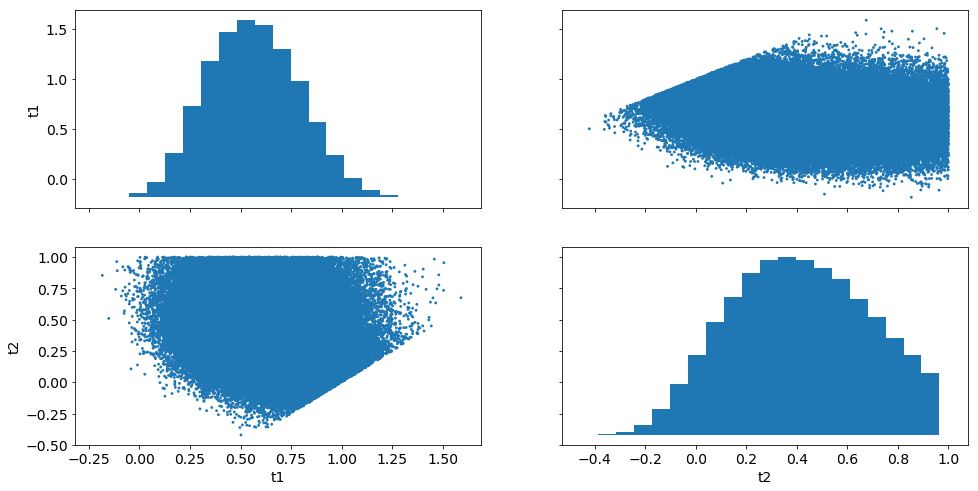

In [63]:
result.plot_pairs(s=8);

## Let's do that in parallel!

Currently ELFI supports the powerful *ipyparallel* library for parallel and distributed computing.

In [64]:
from elfi.clients.multiprocessing import set_as_default
set_as_default()

In [65]:
rej = elfi.Rejection(d, [t1, t2], batch_size=10000)

%time result_parallel = rej.sample(100000, n_sim=1000000)

CPU times: user 864 ms, sys: 28 ms, total: 892 ms
Wall time: 3.04 s


In [66]:
result_parallel.summary()

Method: Rejection
Number of samples: 100000
Number of simulations: 1000000
Threshold: 0.421
Sample means: t1: 0.608, t2: 0.445


## Sequential Monte Carlo ABC (Importance sampling)

In [67]:
smc = elfi.SMC(d, [t1, t2], batch_size=10000)

schedule = [0.7, 0.2, 0.05]

result_smc = smc.sample(1000, schedule)

In [68]:
result_smc.summary()

Method: SMC
Number of samples: 1000
Number of simulations: 160000
Threshold: 0.0493
Sample means: t1: 0.597, t2: 0.505


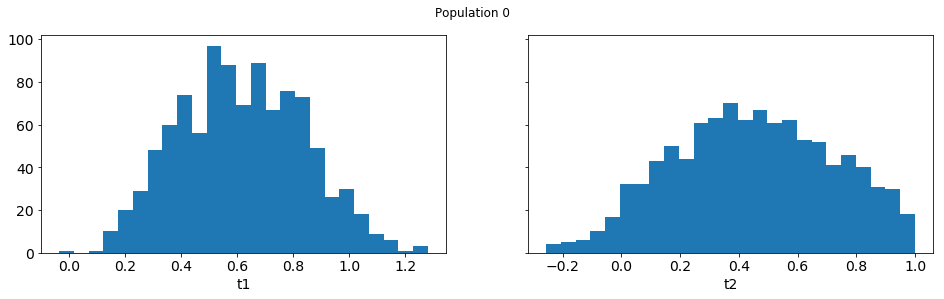

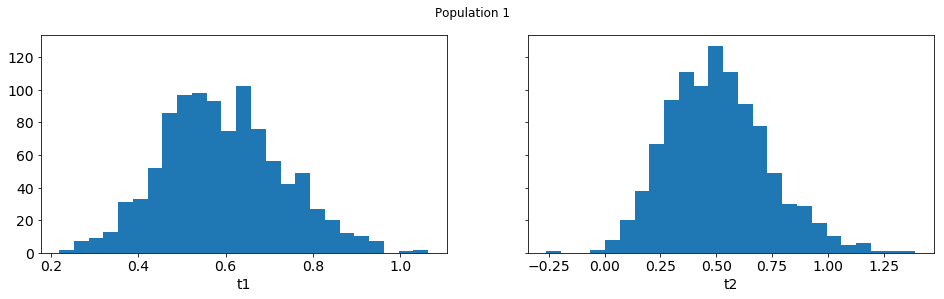

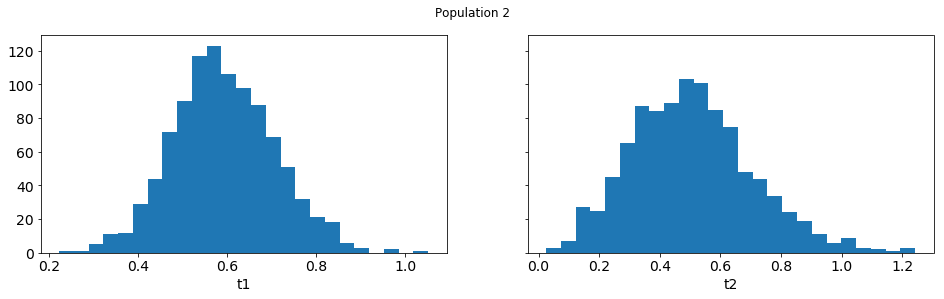

In [69]:
result_smc.plot_marginals(all=True, bins=25, figsize=(1, 1), fontsize=12)

## BOLFI (Bayesian Optimization for Likelihood-Free Inference)

In [70]:
log_d = elfi.Operation(np.log, d)

In [73]:
bolfi = elfi.BOLFI(log_d, batch_size=5, initial_evidence=20, update_interval=10, 
                   bounds={'t1':(-2, 2), 't2':(-1, 1)}, acq_noise_var=[0.1, 0.1], seed=2017)
post = bolfi.fit(n_evidence=200)

### ELFI currently uses GPy for Gaussian processes

In [74]:
bolfi.target_model


Name : GP regression
Objective : 116.25949214295014
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |     priors    
  sum.rbf.variance         |  0.286464982779  |      +ve      |  Ga(0.038, 1) 
  sum.rbf.lengthscale      |  0.638973623776  |      +ve      |   Ga(1.3, 1)  
  sum.bias.variance        |  0.123199543849  |      +ve      |  Ga(0.0095, 1)
  Gaussian_noise.variance  |  0.130922623856  |      +ve      |               

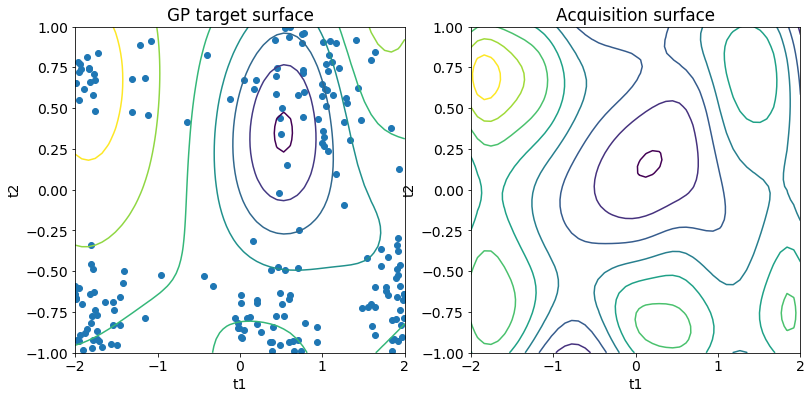

In [75]:
bolfi.plot_state()

In [76]:
# ignore plotting warning
import warnings
warnings.simplefilter("ignore")

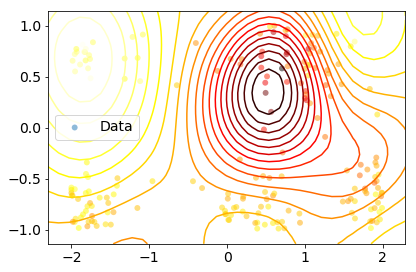

In [77]:
bolfi.target_model._gp.plot();

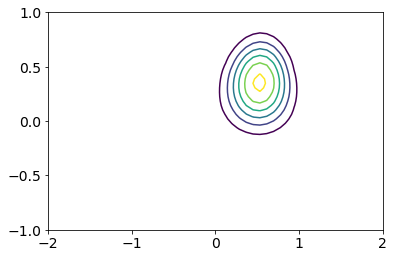

In [78]:
post.plot(logpdf=False)

In [79]:
%time result_bolfi = bolfi.sample(100)

4 chains of 100 iterations acquired. Effective sample size and Rhat for each parameter:
t1 242.489754989 1.01208749956
t2 200.260156127 1.00338508148
CPU times: user 31.6 s, sys: 29.5 s, total: 1min 1s
Wall time: 21min 23s


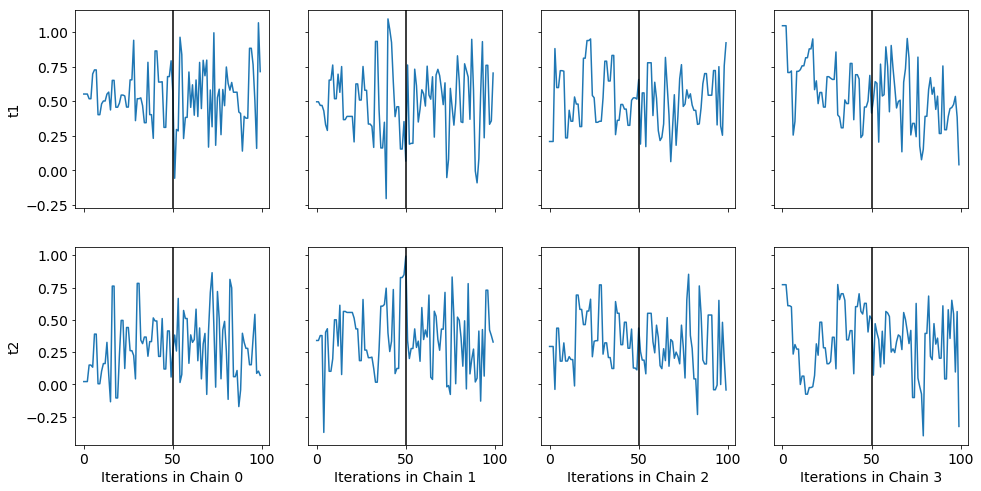

In [80]:
result_bolfi.plot_traces();

In [81]:
result_bolfi.summary()

Method: BOLFI
Number of samples: 200
Number of simulations: 200
Threshold: -1.24
Sample means: t1: 0.504, t2: 0.311
